**This notebook makes a map of ASNs called by or calling to CloudPBX in 1. North America 2. Vancouver. Points representing the locations are coloured by ASN company. Throughout the day, the maps will also include other parameters, such as a value for call quality.**

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import ipaddress
import geoip2.database
from mpl_toolkits.basemap import Basemap, cm
import matplotlib.cm as cm
from collections import OrderedDict
%matplotlib inline

In [2]:
def select_city(city):
    if city == 'Vancouver':
        df = pd.read_csv('../../../pims-bcdata18-cloudpbx/Mohamed/van_rtp_unique_ipwcount.csv')
        map_name = 'Map_Vancouver.png'
        ll_lat_sub, ll_lon_sub, ur_lat_sub, ur_lon_sub = 48.9, -123.4, 49.5, -122.4 
        parallel=0.2
        scale=200

    if city == 'Toronto':
        df = pd.read_csv('../../../pims-bcdata18-cloudpbx/Mohamed/tor_rtp_unique_ipwcount.csv')
        map_name = 'Map_Toronto.png'
        ll_lat_sub, ll_lon_sub, ur_lat_sub, ur_lon_sub = 41, -84, 46, -76
        parallel = 2
        scale=100

    if city == 'Montreal':
        df = pd.read_csv('../../../pims-bcdata18-cloudpbx/Mohamed/mtl_rtp_unique_ipwcount.csv')
        map_name = 'Map_Montreal.png'
        ll_lat_sub, ll_lon_sub, ur_lat_sub, ur_lon_sub = 44, -76, 48, -70
        parallel = 2
        scale=200

    return df, map_name, ll_lat_sub, ll_lon_sub, ur_lat_sub, ur_lon_sub, parallel, scale

Run the code for the 1. Vancouver 2. Toronto 3. Montreal by entering the name of the city. Each city has its own filename, city name (used for the title), domain, intervals for lon/lat parallels, and the scale for the scatter markers.

In [3]:
city = 'Vancouver'
df, map_name, ll_lat_sub, ll_lon_sub, ur_lat_sub, ur_lon_sub, parallel, scale = select_city(city)

Load data. It should include the name of the ASN, along with the coordinates of all its IP addresses.

In [4]:
df.head(1)

,Unnamed: 0,a_saddr,b_saddr,a_saddr_asn,a_saddr_asorg,a_saddr_lat,a_saddr_long,b_saddr_asn,b_saddr_asorg,b_saddr_lat,b_saddr_long,count
0,0,3227975250,1176778026,395152,CloudPBX,43.6319,-79.3716,40029,Novus Entertainment Inc.,49.2788,-123.1139,655


In [5]:
DATA_ROOT = '../data'
GEOLITE_DB_PATH = os.path.join(DATA_ROOT,'GeoLite2-City.mmdb')

Convert ip to coordinates or load coordinates if already available

In [6]:
def findLat(ip):
    try: return reader.city(ip).location.latitude
    except ValueError: return np.nan

def findLon(ip):
    try: return reader.city(ip).location.longitude
    except ValueError: return np.nan

In [7]:
lata = df['a_saddr_lat']
lona = df['a_saddr_long']
latb = df['b_saddr_lat']
lonb = df['b_saddr_long']

Finding unique ASN names - as list

In [8]:
orga = df['a_saddr_asorg']
orgb = df['b_saddr_asorg']
ct = df['count']
unique_ogsb = orgb.unique()
unique_ogsa = orga.unique()

In [9]:
def make_dictionary_colors(unique_ogsb):
    ''' 1. Makes a list of colours
        2. Assigns a unique colour to a unique ASN
    '''
    cm_times = np.linspace(0, 1, len(unique_ogsb))
    colors = [cm.rainbow(x) for x in cm_times]

    dictionary = {}
    for i in range(len(unique_ogsb)):
        dictionary[unique_ogsb[i]] = colors[i]
        
    return dictionary

def make_map(ll_lat, ll_lon, ur_lat, ur_lon, parallels):
    ''' Plots the basic map using:
    lower left lat
    lower left lon
    upper right lat
    upper right lon
    and intervals for drawing the map parallels
    '''
    
    fig = plt.figure(figsize=(20, 16), edgecolor='w')
    m = Basemap(projection='cyl', resolution='h', llcrnrlat=ll_lat, llcrnrlon=ll_lon, urcrnrlat=ur_lat, urcrnrlon=ur_lon)
    m.drawparallels(np.arange(-90.,91.,parallels),labels=[True,False,False,True])
    m.drawmeridians(np.arange(-180.,181.,parallels),labels=[True,False,False,True])
    m.drawcoastlines()
    m.fillcontinents(color='w', lake_color='grey')
    m.drawstates()
    m.drawcountries()
    m.shadedrelief()
    return fig, m

# Wider Map

In [10]:
ll_lat, ll_lon, ur_lat, ur_lon = 22, -130, 65, -55

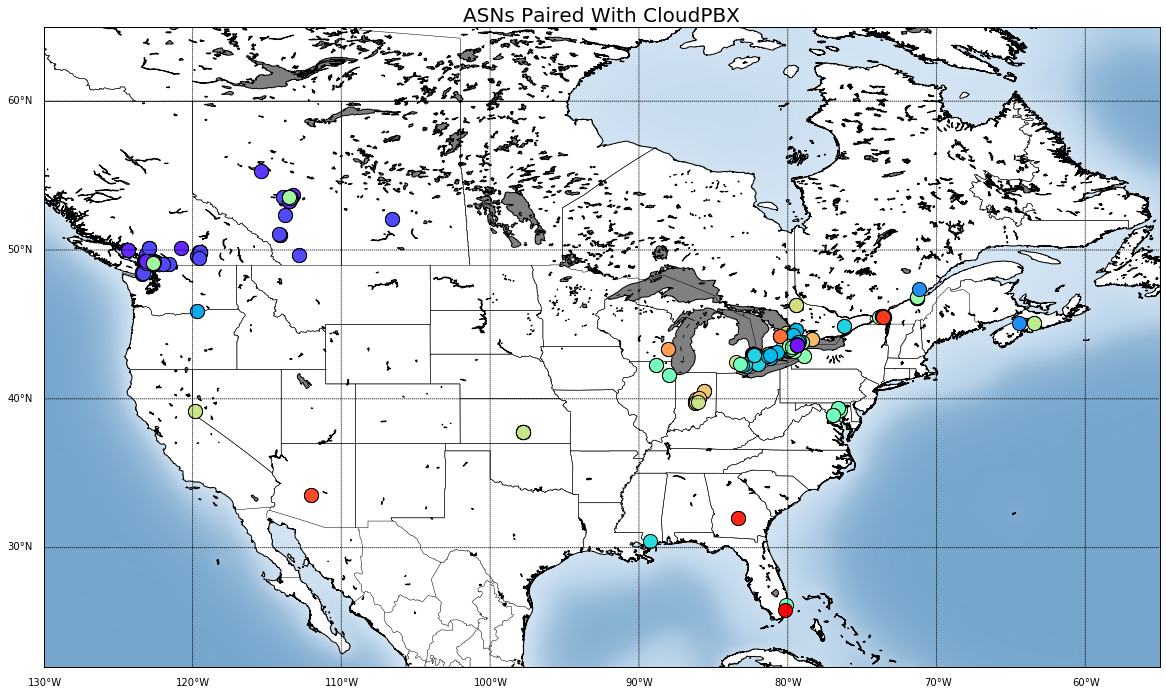

In [11]:
fig, m = make_map(ll_lat, ll_lon, ur_lat, ur_lon, 10)

dictionary = make_dictionary_colors(unique_ogsb)

for i in range(len(latb)):
    orgb_name = orgb[i]
    c = dictionary[orgb_name]
    xb, yb = m(lonb[i], latb[i])
    m.scatter(xb, yb, marker='o', c=c, alpha=1, s=200, zorder=2, label=orgb_name)
    
plt.title('ASNs Paired With CloudPBX', fontsize=20)

plt.show()
fig.savefig('./Map_NorthAmerica.png', dpi=100, bbox_inches='tight')

# City

Narrowing down which ASN's have IP's within the map plot domain

In [12]:
ll_lat, ll_lon, ur_lat, ur_lon = ll_lat_sub, ll_lon_sub, ur_lat_sub, ur_lon_sub

In [13]:
# Find instances that fall only within the plot domain
lat_limits_inds = np.where((latb <= ur_lat) & (latb >= ll_lat))[0]

lon_limits_inds = np.where((lonb <= ur_lon) & (lonb >= ll_lon))[0]

domain_inds = list(set(lat_limits_inds).intersection(lon_limits_inds))

# Find unique companies in the city
orgb_city = []
for i in domain_inds:
    orgb_city.append(orgb[i])

unique_ogsb_city = list(set(orgb_city))

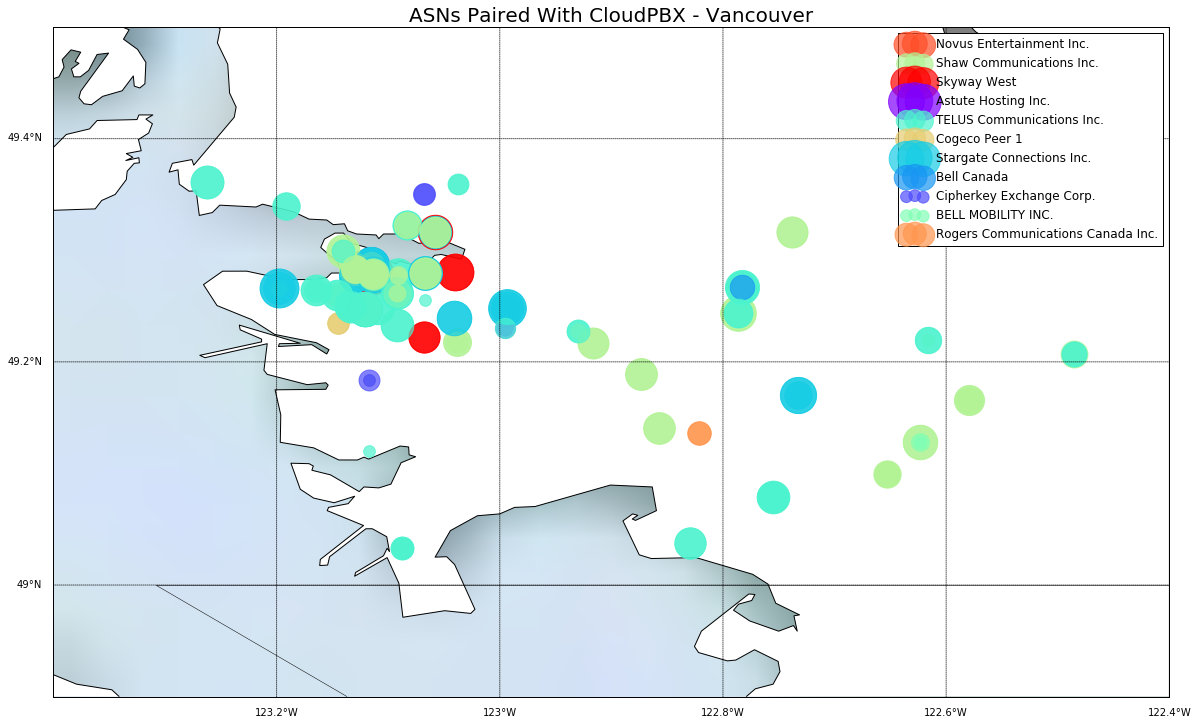

In [14]:
fig, m = make_map(ll_lat, ll_lon, ur_lat, ur_lon, parallel)

dictionary_city = make_dictionary_colors(unique_ogsb_city)

for i in domain_inds:
    orgb_name = orgb[i]
    c = dictionary_city[orgb_name]
    xb, yb = m(lonb[i], latb[i])
    m.scatter(xb, yb, marker='o', c=c, s=scale*np.log(ct[i]), 
              alpha=0.7, zorder=2, label=orgb_name, facecolors=c, edgecolors='face')
    #plt.annotate(str(qual_value[i]), xy=(xb, yb), fontsize=15)

plt.legend(numpoints=1, ncol=3)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.title('ASNs Paired With CloudPBX - '+city, fontsize=20)

plt.show()
fig.savefig('./'+map_name, dpi=100, bbox_inches='tight')